In [1]:
import numpy as np
import simple_mri as sm
import matplotlib.pyplot as plt
import skimage
from matplotlib.colors import ListedColormap, to_rgba
from gmri2fem.segmentation_refinement import resample_segmentation
from gmri2fem.utils import largest_island, find_timestamps
from gmri2fem.visualization import slice_volume
from gmri2fem.visualization import slice_volume

plt.rcParams["font.size"] = 16

In [2]:
timestamps = np.maximum(0, find_timestamps("../mri_dataset/timetable.tsv", "looklocker", "sub-01"))
mask_mri = sm.load_mri("../mri_processed_data/sub-01/segmentations/sub-01_seg-intracranial_binary.nii.gz", dtype=bool)
csf_mask_mri = sm.load_mri("../mri_processed_data/sub-01/segmentations/sub-01_seg-csf_binary.nii.gz", bool)
t1w_mri = sm.load_mri("../mri_processed_data/sub-01/registered/sub-01_ses-01_T2w_registered.nii.gz", dtype=np.single)

In [3]:
t1w = t1w_mri.data
intracranial_mask = mask_mri.data
csf_mask = csf_mask_mri.data
brain_mask = largest_island(intracranial_mask * (~csf_mask))
csf_seg_mri = sm.load_mri("../mri_processed_data/sub-01/segmentations/sub-01_seg-csf-aseg.nii.gz", np.int16)

In [4]:
concentration_path = lambda idx: f"../mri_processed_data/sub-01/concentrations/sub-01_ses-{idx+1:02d}_concentration.nii.gz"
concentration_mris = [sm.load_mri(concentration_path(idx), np.single) for idx in range(5)]

In [5]:
import pint
ureg = pint.UnitRegistry()
mm = ureg.mm
concentration = ureg("1 * mmoles / L")
(concentration * mm**3).to("millimoles")

<Quantity(1e-06, 'millimole')>

In [6]:
print("Total CSF-volume:", 0.5**3 * csf_mask.sum() / 1000, "ml")
C = np.stack([mri.data for mri in concentration_mris], axis=-1)
intracranial_total = 0.5**3 * np.nansum(C[intracranial_mask], axis=0) * 1e-6
brain_total = 0.5**3 * np.nansum(C[brain_mask], axis=0) * 1e-6
csf_total = 0.5**3 * np.nansum(C[csf_mask], axis=0) * 1e-6

for total in [intracranial_total, brain_total, csf_total]:
    print([f"{xi:.2e}" for xi in total])
    


Total CSF-volume: 402.591625 ml
['0.00e+00', '7.85e-02', '1.18e-01', '8.59e-02', '5.06e-02']
['0.00e+00', '1.64e-02', '5.19e-02', '4.53e-02', '2.93e-02']
['0.00e+00', '6.16e-02', '6.55e-02', '4.01e-02', '2.11e-02']


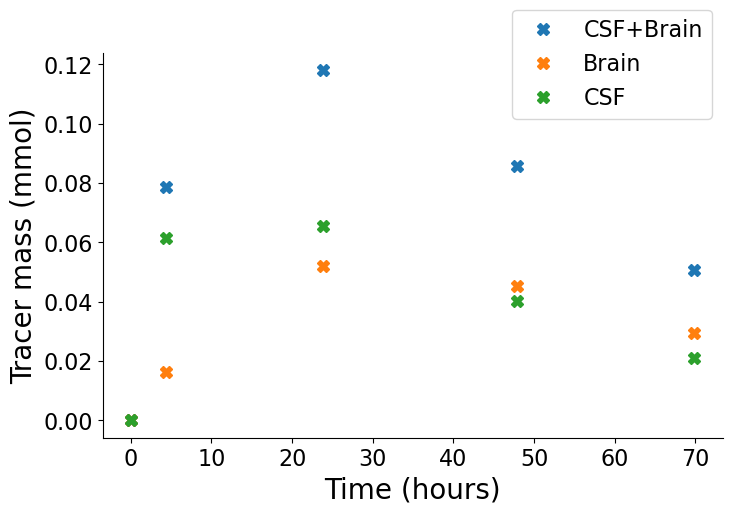

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, intracranial_total, "X", markersize=8, label="CSF+Brain")
plt.plot(timestamps, brain_total, "X", markersize=8, label="Brain")
plt.plot(timestamps, csf_total, "X", markersize=8, label="CSF")
plt.yticks(np.linspace(0, 0.12, 7))
plt.xticks([3600 * i for i in np.arange(0, 73, 10)], [i for i in np.arange(0, 73, 10)])
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Tracer mass (mmol)", fontsize=20)
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.8))
plt.gca().spines[["top", "right"]].set_visible(False)
plt.savefig("../figures/tracer-mass.pdf", bbox_inches="tight")
plt.show()

In [8]:
csf_color = '#3383ff'  # Change this to any color you like
csf_colors = [(0, 0, 0, 0), to_rgba(csf_color)]  # (R,G,B,A) for transparent and your color
csf_cmap = ListedColormap(csf_colors)

In [9]:
brain_color = '#b8b4b4'  # Change this to any color you like
brain_colors = [(0, 0, 0, 0), to_rgba(brain_color)]  # (R,G,B,A) for transparent and your color
brain_cmap = ListedColormap(brain_colors)

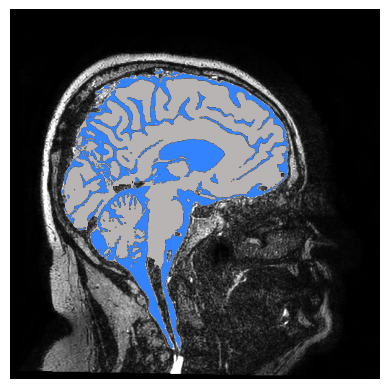

In [10]:
slice_ = ("sagittal", 190)
plt.figure()
plt.imshow(slice_volume(t1w, *slice_), cmap="gray", vmax=5e4)
plt.imshow(np.where(slice_volume(csf_mask, *slice_), 1.0, np.nan), cmap=csf_cmap, vmin=0, vmax=1)
plt.imshow(np.where(slice_volume(brain_mask, *slice_), 1.0, np.nan), cmap=brain_cmap, vmin=0, vmax=1)
plt.axis("off")
plt.savefig("../figures/intracranial-mask.pdf", bbox_inches="tight")
plt.show()

In [11]:
lower_csf = np.isin(csf_seg_mri.data, [8, 47])
lower_csf = np.isin(csf_seg_mri.data, [16])
median, mean, std = np.nanmedian(C[lower_csf, -1]), np.nanmean(C[lower_csf, -1]), np.nanstd(C[lower_csf, -1])
median, mean, std

(np.float32(0.02990313), np.float32(0.027388511), np.float32(0.026245316))

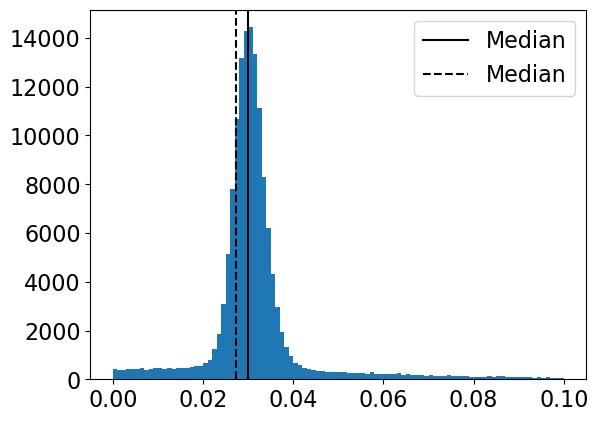

In [12]:
plt.hist(C[lower_csf, -1], bins=100, range=[0, 0.1])
plt.axvline(median, color="k", label="Median")
plt.axvline(mean, color="k", ls="--", label="Median")
plt.legend()
plt.show()